In [2]:
import multiprocessing

In [3]:
# NumPy, SciPy, Numba
import numpy as np
import scipy.stats as st
import scipy.integrate as integrate
import scipy.linalg as lg
import numba

In [4]:
# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [6]:
# Seaborn settings for notebook
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'whitesmoke'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [7]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0, 0],
                          [-1, 1, 0],
                          [-1, 0, 1],
                          [-1, 0, 0],
                          [0, -1, 0],
                          [0, 0, -1]], dtype=np.int64)

In [8]:
@numba.jit(nopython=True)
def simple_propensity_numba(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    b_Rl, b_L, b_S, d_Rl, d_L, d_S, V = params
    
    # Unpack population
    Rl, L, S = population
    
    return np.array([b_Rl * L, 
                     b_L * Rl,
                     b_S * Rl*S/V,
                     d_Rl * Rl,
                     d_L * L,
                     d_S * S])

In [9]:
@numba.jit(nopython=True)
def sum_numba(ar):
    return ar.sum()

In [10]:
@numba.jit(nopython=True)
def sample_discrete_numba(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [11]:
# Function to draw time interval and choice of reaction
@numba.jit(nopython=True)
def gillespie_draw_numba(params, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = simple_propensity_numba(params, population)
    
    # Sum of propensities
    props_sum = sum_numba(props)
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete_numba(rxn_probs)
    
    return rxn, time

In [12]:
@numba.jit(nopython=True)
def gillespie_ssa_numba(params, update, population_0, time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_numba(params, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

In [13]:
def gillespie_fn(args):
    return gillespie_ssa_numba(*args)
    
def gillespie_parallel(fn, params, update, population_0, time_points, n_simulations, n_threads):
    """
    Convenience function to do parallel Gillespie simulations for simple
    gene expression.
    """
    input_args = (params, update, population_0, time_points)

    with multiprocessing.Pool(n_threads) as p:
        populations = p.map(fn, [input_args]*n_simulations)
        
    return np.array(populations)

In [14]:
# Specify parameters for calculation
params = np.array([2., 1., 1., 2., 0.5, 0.5, 500.])
time_points = np.linspace(0, 2500, 2501)
population_0 = np.array([0, 250, 250])
n_simulations = 1000

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 3))

# Run the calculations
pops = gillespie_parallel(gillespie_fn, params, simple_update, population_0, time_points, n_simulations, 10)

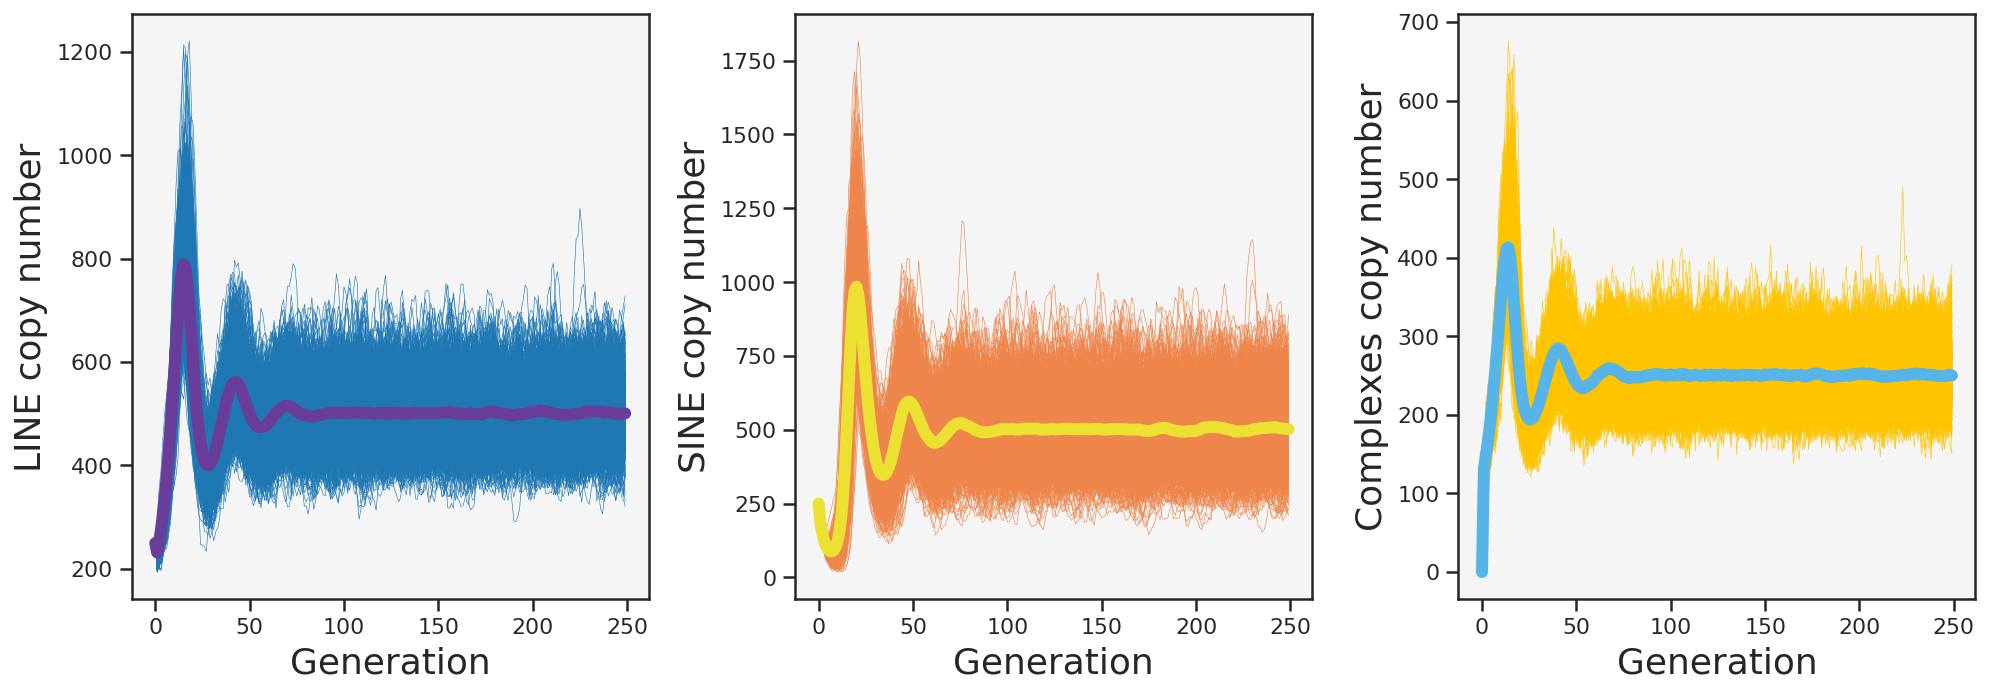

In [15]:
# Set up subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Plot LINE trajectories
for i in range(n_simulations):
    ax[0].plot(time_points[0:250], pops[i,0:250,1], '-', lw=0.3, alpha=1, 
               color=sns.color_palette("Paired")[1])

# Plot LINE mean
ax[0].plot(time_points[0:250], pops[:,0:250,1].mean(axis=0), '-', lw=6, 
           color=sns.color_palette("Paired")[9])

# Plot SINE trajectories
for i in range(n_simulations):
    ax[1].plot(time_points[0:250], pops[i,0:250,2], '-', lw=0.3, alpha=1,
               color=sns.color_palette("muted")[1])

# Plot SINE mean
ax[1].plot(time_points[0:250], pops[:,0:250,2].mean(axis=0), '-', lw=6, 
           color=sns.color_palette("colorblind")[8])

# Plot Ribosome_complexes trajectories
for i in range(n_simulations):
    ax[2].plot(time_points[0:250], pops[i,0:250,0], '-', lw=0.3, alpha=1, 
               color=sns.color_palette("bright")[8])

# Plot Ribosome_complexes mean
ax[2].plot(time_points[0:250], pops[:,0:250,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette("colorblind")[9])

# Label axes
ax[0].set_xlabel('Generation')
ax[1].set_xlabel('Generation')
ax[2].set_xlabel('Generation')
ax[0].set_ylabel('LINE copy number')
ax[1].set_ylabel('SINE copy number')
ax[2].set_ylabel('Complexes copy number')
plt.tight_layout()

In [161]:
# Analytical solution
b_Rl, b_L, b_S, d_Rl, d_L, d_S, V = params
y0 = np.array([0.1, 0.25, 0.25])
t_span = np.array([0, 2500])
t = np.arange(0,2500,0.1)
@numba.jit(nopython=True)
def solve_syst(t, y, b_Rl, b_L, b_S, d_RL, d_L, d_S):
    Rl, L, S = y
    dydt = [b_Rl*L-b_L*Rl-b_S*S*Rl-d_Rl*Rl, b_L*Rl-d_L*L, b_S*S*Rl-d_S*S]
    return dydt
sol2 = integrate.solve_ivp(solve_syst, t_span, y0, t_eval=t, 
                           args=(b_Rl, b_L, b_S, d_Rl, d_L, d_S), dense_output=True)

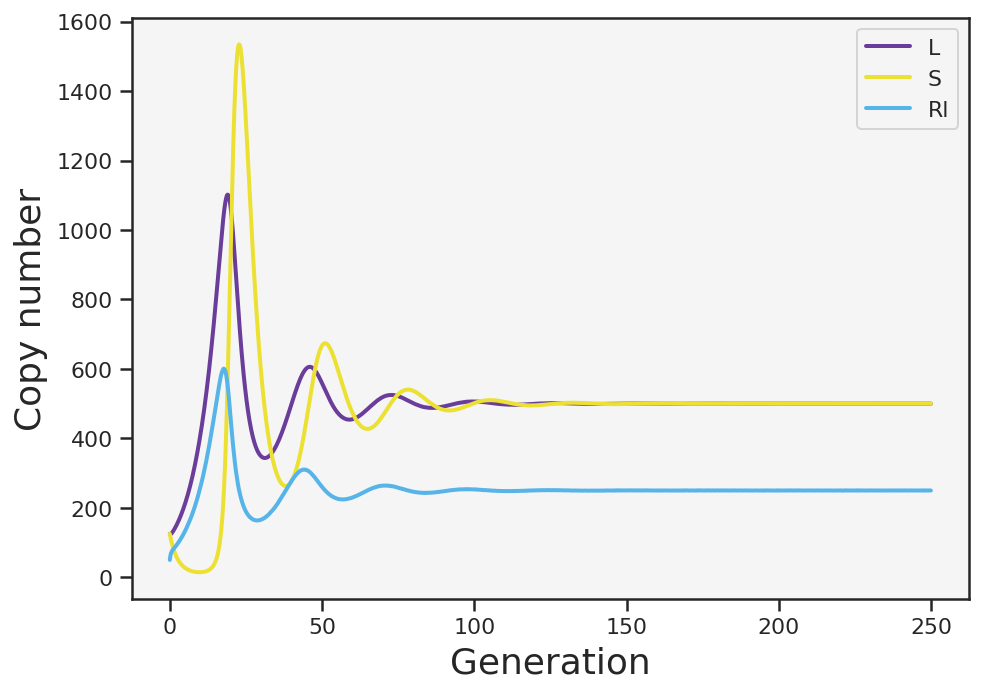

In [162]:
# Plot analytical solution for first 250 generations
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(sol2.t[0:2500], V*sol2.y[1,0:2500], '-', lw=2, 
           color=sns.color_palette("Paired")[9], label="L")
ax.plot(sol2.t[0:2500], V*sol2.y[2,0:2500], '-', lw=2, 
           color=sns.color_palette("colorblind")[8], label="S")
ax.plot(sol2.t[0:2500], V*sol2.y[0,0:2500], '-', lw=2, 
           color=sns.color_palette("colorblind")[9], label="Rl")

# Label axes
ax.set_xlabel('Generation')
ax.set_ylabel('Copy number')
plt.tight_layout()
plt.legend(loc='best')
ax.axis('auto')
plt.show()

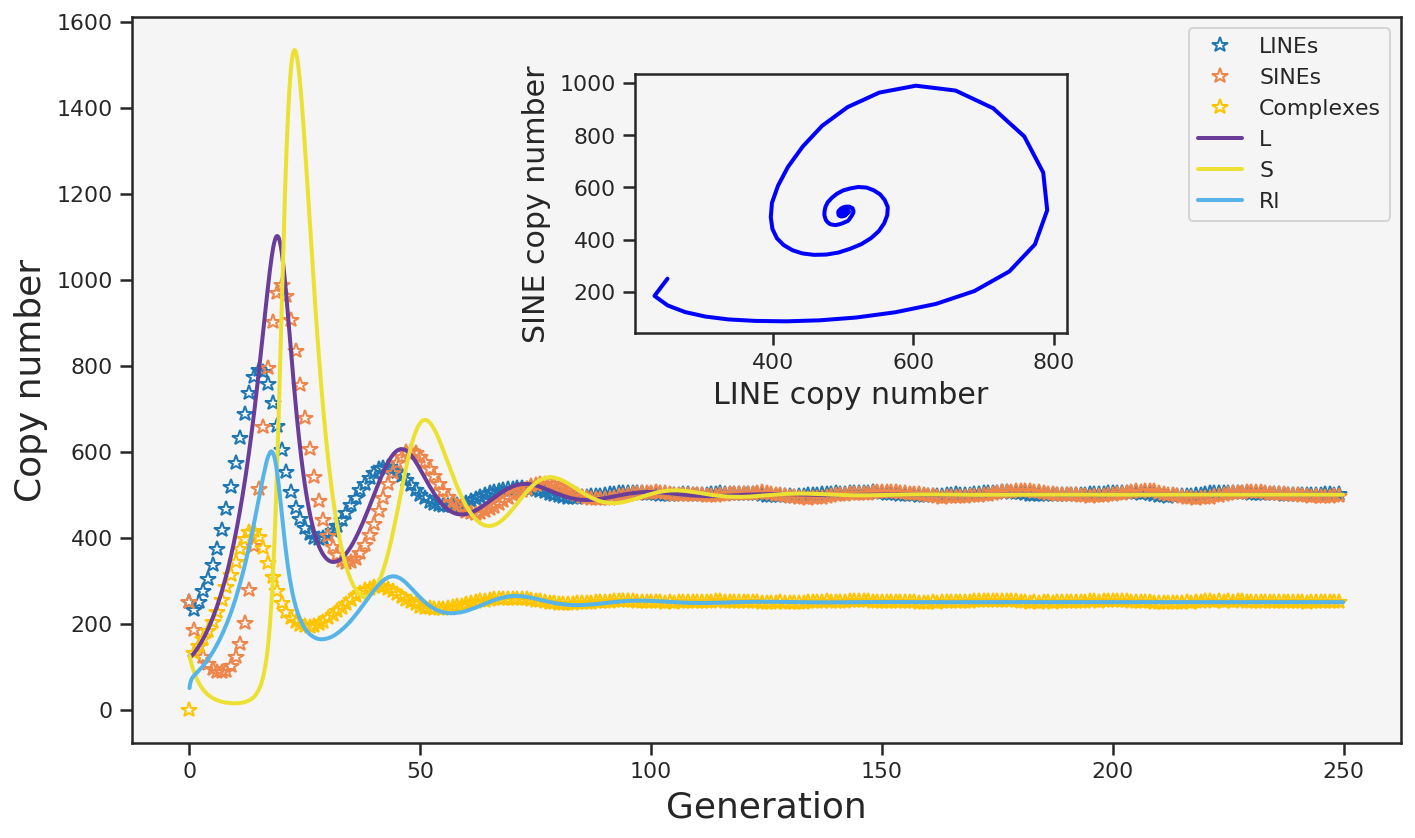

In [139]:
# Plot both solutions together
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_points[0:250], pops[:,0:250,1].mean(axis=0), '*', markersize=8, fillstyle='none',
           color=sns.color_palette("Paired")[1], label="LINEs")
ax.plot(time_points[0:250], pops[:,0:250,2].mean(axis=0), '*', markersize=8, fillstyle='none',
           color=sns.color_palette("muted")[1], label="SINEs")
ax.plot(time_points[0:250], pops[:,0:250,0].mean(axis=0), '*', markersize=8, fillstyle='none',
           color=sns.color_palette("bright")[8], label="Complexes")
ax.plot(sol2.t[0:2500], 500*sol2.y[1,0:2500], '-', lw=2, 
           color=sns.color_palette("Paired")[9], label="L")
ax.plot(sol2.t[0:2500], 500*sol2.y[2,0:2500], '-', lw=2, 
           color=sns.color_palette("colorblind")[8], label="S")
ax.plot(sol2.t[0:2500], 500*sol2.y[0,0:2500], '-', lw=2, 
           color=sns.color_palette("colorblind")[9], label="Rl")

# Label axes
ax.set_xlabel('Generation')
ax.set_ylabel('Copy number')
plt.tight_layout()
plt.legend(loc='best')
ax.axis('auto')

# Plot inside figure
left, bottom, width, height = [0.45, 0.6, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
plt.plot(pops[:,:,1].mean(axis=0), pops[:,:,2].mean(axis=0), 'b')
ax2.set_xlabel('LINE copy number', fontsize=15)
ax2.set_ylabel('SINE copy number', fontsize=15)
plt.show()

In [163]:
# Find linear stability matrix eigenvalues
Matr = np.array([[-d_L, 0, b_L],
               [0, 0, b_Rl/d_L-b_L-d_Rl],
               [b_Rl, -d_S, -b_Rl/d_L]])
eigvals = lg.eigvals(Matr)
print(eigvals)

[-4.39926213+0.j         -0.05036893+0.23300361j -0.05036893-0.23300361j]


In [144]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] *2*np.pi
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2 *2*np.pi
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

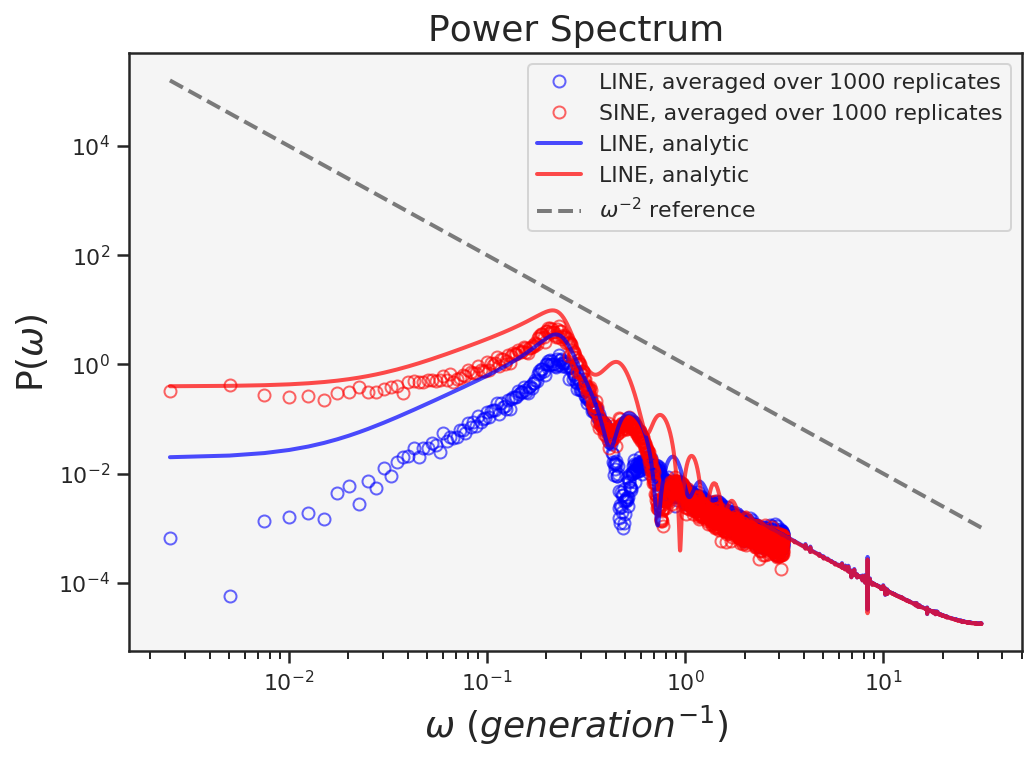

In [145]:
freqs1, ps1, psd1 = spectrum1(pops[:,:,1].mean(axis=0), dt=1) 
freqs2, ps2, psd2 = spectrum1(pops[:,:,2].mean(axis=0), dt=1)
Freqs1, Ps1, Psd1 = spectrum1(500*sol2.y[1,:], dt=0.1)
Freqs2, Ps2, Psd2 = spectrum1(500*sol2.y[2,:], dt=0.1)

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.loglog(freqs1, ps1, 'bo', fillstyle='none',
          label='LINE, averaged over 1000 replicates', alpha=0.6)
ax.loglog(freqs2, ps2, 'ro', fillstyle='none',
          label='SINE, averaged over 1000 replicates', alpha=0.6)
ax.loglog(Freqs1, Ps1, 'b', label='LINE, analytic', alpha=0.7)
ax.loglog(Freqs2, Ps2, 'r', label='LINE, analytic', alpha=0.7)
ax.loglog(Freqs1, Freqs1**(-2), linestyle='--', label='$\omega^{-2}$ reference', alpha=0.5, color="black")
ax.set_title('Power Spectrum')
plt.xlabel('$\omega$ ($generation^{-1}$)')
plt.ylabel('P($\omega$)')
plt.legend(loc='best')
ax.axis('tight', which='x')
plt.show()